# Find Flat Pairs

In this notebook I try to query all flat pairs that have low flux.

In [1]:
date = '19May22'
print(f'Running this code on {date}')

Running this code on 19May22


In [2]:
import sys, os, glob, time
import numpy as np
import pandas as pd
import astropy.io.fits as pf
import matplotlib.pyplot as plt
import lsst.daf.butler as dafButler

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')

In [370]:
df = pd.read_csv('file1.csv',index_col=0)
df

,day,seq_num,exposure_id,exposure_time,time,Flux
2022050500290,20220505,290,2022050500290,6.000,2022-05-05T21:10:30.745000,93916.906250
2022050500289,20220505,289,2022050500289,6.000,2022-05-05T21:10:22.010989,93915.421875
2022050500288,20220505,288,2022050500288,5.700,2022-05-05T21:10:13.430992,89182.718750
2022050500287,20220505,287,2022050500287,5.700,2022-05-05T21:10:04.884991,89178.546875
2022050500286,20220505,286,2022050500286,5.399,2022-05-05T21:09:56.639009,84433.390625
...,...,...,...,...,...,...
2021011900085,20210119,85,2021011900085,2.000,2021-01-19T21:00:19.388773,63845.308594
2021011900084,20210119,84,2021011900084,2.000,2021-01-19T21:00:14.845447,63844.906250
2021011900083,20210119,83,2021011900083,2.000,2021-01-19T21:00:10.286715,63846.636719
2021011900082,20210119,82,2021011900082,2.000,2021-01-19T21:00:05.738265,63845.871094


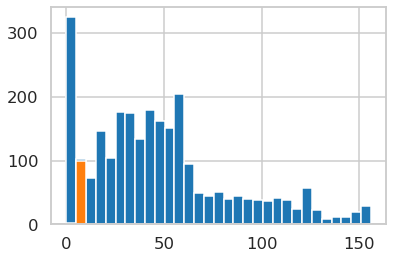

In [381]:
flux = df.Flux.to_numpy()*1e-3
mask = (flux<10)&(flux>5)

a = plt.hist(flux, bins=31)
a = plt.hist(flux[mask], bins=a[1])


In [382]:
print(np.count_nonzero(mask))

102


In [405]:
df2 = df.iloc[mask].copy()
df2

,day,seq_num,exposure_id,exposure_time,time,Flux
2022050500254,20220505,254,2022050500254,0.6,2022-05-05T21:06:41.184990,9356.223633
2022050500253,20220505,253,2022050500253,0.6,2022-05-05T21:06:35.608999,9355.787109
2022050500135,20220505,135,2022050500135,0.5,2022-05-05T20:22:20.176007,7796.404297
2022050500134,20220505,134,2022050500134,0.5,2022-05-05T20:22:17.125008,7794.852539
2022050400139,20220504,139,2022050400139,0.6,2022-05-04T20:21:05.397012,8893.919922
...,...,...,...,...,...,...
2021012100540,20210121,540,2021012100540,0.2,2021-01-21T21:15:31.416373,6242.013184
2021011900096,20210119,96,2021011900096,0.3,2021-01-19T21:03:36.458404,9585.971680
2021011900095,20210119,95,2021011900095,0.3,2021-01-19T21:03:33.611463,9586.920898
2021011900094,20210119,94,2021011900094,0.2,2021-01-19T21:03:30.767340,6393.916992


In [388]:
df_all = df2.to_numpy().T
exposures = df_all[2]
days = df_all[0]
seq_num = df_all[1]
exp_time = df_all[3]
times = df_all[4]

In [389]:
temp_data = np.full(len(df2), np.nan, 
                    dtype=[('t1', float), 
                          ('t1_err', float),
                          ('t2', float), 
                          ('t2_err', float)])

In [433]:
np.arange(0,len(df2),2)

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100])

In [447]:
# get the temperature
from lsst_efd_client import EfdClient, resample
efd_client = EfdClient('ldf_stable_efd')

for ii in np.arange(0,len(df2),2):
    exposure = exposures[ii]
    time1 = Time(times[ii+1], format='isot', scale='tai')
    time2 = Time(times[ii], format='isot', scale='tai')
    
    if exposure < 20211013:
        # EFD was switched to UTC on 20211013.  This compensates for that.
        tai_offset = 37.0
    else:
        tai_offset = 0.0
    t1 = time1 - TimeDelta(-5., format='sec', scale='tai')
    t2 = time2 + TimeDelta(+5., format='sec', scale='tai')
    
    res1 = await efd_client.select_time_series("lsst.sal.ATCamera.focal_plane_Reb", 
                                               ["aspicl_Temp00","aspicu_Temp00"], 
                                               t1.utc - TimeDelta(tai_offset, format='sec'), 
                                               t2.utc - TimeDelta(tai_offset, format='sec'))
    #print(res1)
    if len(res1)>0:
        t1 = np.mean(res1['aspicl_Temp00'])
        t1_err = np.std(res1['aspicl_Temp00'])
        t2 = np.mean(res1['aspicu_Temp00'])
        t2_err = np.std(res1['aspicu_Temp00'])

        temp_data[ii] = (t1, t1_err, t2, t2_err)
        temp_data[ii+1] = (t1, t1_err, t2, t2_err)


In [448]:
temp_data['t1']

array([16.4955349 , 16.4955349 , 16.59116043, 12.76724605, 15.89285755,
       15.89285755, 15.9151783 , 15.9151783 , 19.8883934 , 19.8883934 ,
       19.6205349 , 19.6205349 , 16.2276783 , 16.2276783 , 16.2723217 ,
       16.2723217 , 16.2276783 , 16.2276783 , 12.08079897, 16.42526457,
       16.42526457, 16.3839283 , 16.3839283 , 15.61885771, 14.0625    ,
       14.0625    , 14.10714245, 14.10714245, 14.0625    , 14.0625    ,
       14.0625    , 14.24107122, 14.0401783 , 14.0401783 , 14.2410717 ,
       14.2410717 ,         nan,         nan, 14.1964283 , 14.1964283 ,
       14.88839245, 14.88839245,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [429]:
outname = 'flat_field_pairs_auxTel_2022.csv'
df2['Temp1'] = temp_data['t1']
df2['TempErr1'] = temp_data['t1_err']
df2['Temp2'] = temp_data['t2']
df2['TempErr2'] = temp_data['t2_err']
df2.to_csv(outname)

In [431]:

# with pd.option_context('display.max_rows', None,):
print(df2[['day','Temp1']].iloc[nan])

                    day  Temp1
2022022400051  20220224    NaN
2022022400050  20220224    NaN
2021120200079  20211202    NaN
2021120200078  20211202    NaN
2021101300136  20211013    NaN
...                 ...    ...
2021012100540  20210121    NaN
2021011900096  20210119    NaN
2021011900095  20210119    NaN
2021011900094  20210119    NaN
2021011900093  20210119    NaN

[62 rows x 2 columns]


In [446]:
nan = np.isnan(temp_data['t1'])
nnan = ~nan
print(np.count_nonzero(nnan))
df2.iloc[nnan]

40


,day,seq_num,exposure_id,exposure_time,time,Flux,Temp1,TempErr1,Temp2,TempErr2
2022050500254,20220505,254,2022050500254,0.6,2022-05-05T21:06:41.184990,9356.223633,16.495535,0.000000,16.495535,0.000000
2022050500253,20220505,253,2022050500253,0.6,2022-05-05T21:06:35.608999,9355.787109,16.495535,0.000000,16.495535,0.000000
2022050500135,20220505,135,2022050500135,0.5,2022-05-05T20:22:20.176007,7796.404297,16.591160,0.104821,16.601613,0.105397
2022050500134,20220505,134,2022050500134,0.5,2022-05-05T20:22:17.125008,7794.852539,12.767246,2.774818,12.777213,2.774804
2022050400139,20220504,139,2022050400139,0.6,2022-05-04T20:21:05.397012,8893.919922,15.892858,0.000000,15.915178,0.000000
2022050400138,20220504,138,2022050400138,0.6,2022-05-04T20:20:59.856990,8893.790039,15.892858,0.000000,15.915178,0.000000
2022050400137,20220504,137,2022050400137,0.4,2022-05-04T20:20:56.622005,5930.101562,15.915178,0.000000,16.049107,0.000000
2022050400136,20220504,136,2022050400136,0.4,2022-05-04T20:20:51.322013,5930.240723,15.915178,0.000000,16.049107,0.000000
2022050300098,20220503,98,2022050300098,0.6,2022-05-03T19:38:12.466007,8583.586914,19.888393,0.000000,19.888393,0.000000
2022050300097,20220503,97,2022050300097,0.6,2022-05-03T19:38:06.933991,8583.512695,19.888393,0.000000,19.888393,0.000000


<AxesSubplot:>

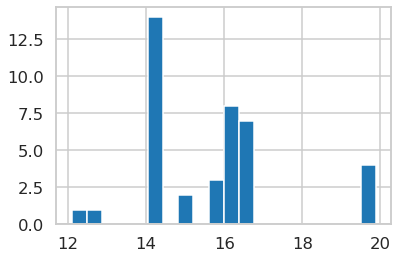

In [438]:
df2.iloc[nnan].Temp2.hist(bins=20)

In [441]:
EfdClient.list_efd_names()

['summit_efd',
 'ncsa_teststand_efd',
 'ldf_stable_efd',
 'ldf_int_efd',
 'base_efd',
 'tucson_teststand_efd',
 'test_efd']

In [440]:
print('Flat Fields Pairs')
print(f'in all flux range: {len(df)/2}')
print(f'between 5k and 10k ADU: {len(df2)/2}')
print(f'with temperature: {np.count_nonzero(nnan)/2}')

Flat Fields Pairs
in all flux range: 1315.0
between 5k and 10k ADU: 51.0
with temperature: 20.0


## Searching on Butler

We retrieve all flat fields on the exposure history since 2021. The flat pairs are defined as consenquently exposures with same exposure. 

In [290]:
import lsst.daf.butler as dafButler
butler = dafButler.Butler("/repo/main", collections=["LATISS/raw/all","LATISS/calib"])
registry = butler.registry

In [291]:
# find all days with some exposure
refs = sorted(registry.queryDatasets('raw', collections=["LATISS/raw/all","LATISS/calib"], instrument='LATISS'))
exposure_all = [int(refs[i].dataId['exposure']) for i in range(len(refs))]
days_all = [int(str(exposure)[:8]) for exposure in exposure_all]
days_all = np.unique(days_all)

In [292]:
# taking exposures since 2020
days = days_all[(days_all>20220000)&(days_all<20230000)]
days = np.flip(days,0)

In [293]:
days

array([20220511, 20220505, 20220504, 20220503, 20220502, 20220429,
       20220428, 20220427, 20220426, 20220425, 20220422, 20220421,
       20220414, 20220407, 20220406, 20220405, 20220404, 20220329,
       20220325, 20220324, 20220318, 20220317, 20220316, 20220315,
       20220314, 20220311, 20220308, 20220304, 20220224, 20220223,
       20220217, 20220216, 20220215, 20220211, 20220209, 20220208,
       20220207, 20220204, 20220203])

In [296]:
# find all the flats
flat_ids = []
info_list = []
for dayObs in days:
    exposureList = []
    for record in butler.registry.queryDimensionRecords("exposure", where="exposure.day_obs=%d"%dayObs):
        exposureList.append([record.id, record])
    exposureList.sort(key=lambda x: x[0])
    for [id,record] in exposureList:
        info_dict = dict()
        if record.observation_type=='flat':
            info_dict['day'] = int(record.day_obs)
            info_dict['seq_num'] = int(record.seq_num)
            info_dict['exposure_id'] = int(record.id)
            info_dict['exposure_time'] = float(record.exposure_time)
            info_dict['time'] = record.timespan.begin.isot
            flat_ids.append(int(record.id))
            info_list.append(info_dict)

In [297]:
import pandas as pd
df = pd.DataFrame(info_list, index=np.array(flat_ids))
df

,day,seq_num,exposure_id,exposure_time,time
2022050500003,20220505,3,2022050500003,3.0,2022-05-05T19:09:58.392999
2022050500120,20220505,120,2022050500120,1.5,2022-05-05T20:08:36.819982
2022050500121,20220505,121,2022050500121,1.5,2022-05-05T20:08:40.885983
2022050500122,20220505,122,2022050500122,3.0,2022-05-05T20:08:44.944983
2022050500123,20220505,123,2022050500123,3.0,2022-05-05T20:08:50.501984
...,...,...,...,...,...
2022020700024,20220207,24,2022020700024,1.0,2022-02-07T17:47:29.104158
2022020700025,20220207,25,2022020700025,1.0,2022-02-07T17:47:32.731887
2022020700026,20220207,26,2022020700026,15.0,2022-02-07T17:47:43.260262
2022020700027,20220207,27,2022020700027,15.0,2022-02-07T17:48:55.991298


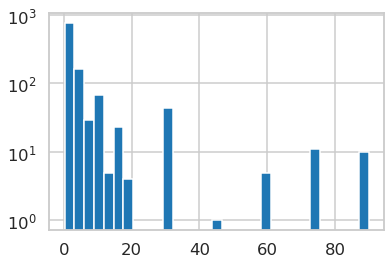

In [298]:
df.exposure_time.hist(bins=31)
plt.yscale('log')

In [311]:
df_all = df.to_numpy().T
exposures = df_all[2]
days = df_all[0]
seq_num = df_all[1]
exp_time = df_all[3]
times = df_all[4]

In [351]:
# flat pairs
# are consecutives exposures on the same day
# with exposure time lower than 20 sec
exp_time_th = exp_time[1:]<20.
consec_exposures = ((seq_num[1:]-seq_num[:-1])==1)&(days[1:]==days[:-1])
pairs = (exp_time[1:] == exp_time[:-1])&(consec_exposures)&exp_time_th
pairs_idx = np.where(pairs)[0]

# for tests purposes
# pairs_idx = pairs_idx[:20]
good_indices = np.unique(np.hstack([pairs_idx,pairs_idx+1]))
good_indices = good_indices[np.argsort(-1*exposures[good_indices])]


In [301]:
df.iloc[pairs_idx]

,day,seq_num,exposure_id,exposure_time,time
2022050500120,20220505,120,2022050500120,1.5,2022-05-05T20:08:36.819982
2022050500122,20220505,122,2022050500122,3.0,2022-05-05T20:08:44.944983
2022050500134,20220505,134,2022050500134,0.5,2022-05-05T20:22:17.125008
2022050500136,20220505,136,2022050500136,1.0,2022-05-05T20:22:23.233001
2022050500138,20220505,138,2022050500138,2.0,2022-05-05T20:22:30.587980
...,...,...,...,...,...
2022020700022,20220207,22,2022020700022,1.0,2022-02-07T17:47:21.853824
2022020700023,20220207,23,2022020700023,1.0,2022-02-07T17:47:25.470943
2022020700024,20220207,24,2022020700024,1.0,2022-02-07T17:47:29.104158
2022020700026,20220207,26,2022020700026,15.0,2022-02-07T17:47:43.260262


In [310]:
# pd.to_timestamp(df.time)

In [328]:
good_indices = np.unique(np.hstack([pairs_idx,pairs_idx+1]))
good_indices = good_indices[np.argsort(-1*exposures[good_indices])]

In [329]:
df.iloc[good_indices]

,day,seq_num,exposure_id,exposure_time,time,temp1
2022050500290,20220505,290,2022050500290,6.000,2022-05-05T21:10:30.745000,-99.0
2022050500289,20220505,289,2022050500289,6.000,2022-05-05T21:10:22.010989,-99.0
2022050500288,20220505,288,2022050500288,5.700,2022-05-05T21:10:13.430992,-99.0
2022050500287,20220505,287,2022050500287,5.700,2022-05-05T21:10:04.884991,-99.0
2022050500286,20220505,286,2022050500286,5.399,2022-05-05T21:09:56.639009,-99.0
...,...,...,...,...,...,...
2022020700015,20220207,15,2022020700015,1.000,2022-02-07T17:46:56.457702,-99.0
2022020700014,20220207,14,2022020700014,1.000,2022-02-07T17:46:52.836514,-99.0
2022020700013,20220207,13,2022020700013,1.000,2022-02-07T17:46:49.218730,-99.0
2022020700012,20220207,12,2022020700012,1.000,2022-02-07T17:46:45.598310,-99.0


### Retrieving the Corrected Flux

To have a better estimate of the gain, we will use only low flux flat pairs.

In [308]:
from lsst.summit.utils.bestEffort import BestEffortIsr
bestEffort = BestEffortIsr()

def get_flux(day, seq):
    dataId = {'day_obs': day, 'seq_num': seq, 'detector':0}
    exp = bestEffort.getExposure(dataId)
    return np.nanmedian(exp.image.array.flatten())

Using bestEffor

```
from lsst.summit.utils.bestEffort import BestEffortIsr
bestEffort = BestEffortIsr()
dataId = {'day_obs': 20200312, 'seq_num': 197, 'detector':0}
exp = bestEffort.getExposure(dataId)
```
or

```
import lsst.summit.utils.butlerUtils as butlerUtils
butler = butlerUtils.makeDefaultLatissButler()
dataId = {'day_obs': 20200312, 'seq_num': 197, 'detector':0}
exp = butler.get('quickLookExp', dataId)
```

In [246]:
from joblib import Parallel, delayed
t0 = time()
tables = Parallel(n_jobs=2)(delayed(get_flux)(days[i], seq_num[i]) for i in pairs_idx[:20)
print(time()-t0)

8.058547973632812e-05


In [247]:
tables

[23409.484,
 46893.875,
 7794.8525,
 15606.193,
 31261.387,
 39095.953,
 46925.453,
 62546.547,
 78153.74,
 86014.28,
 93921.05,
 31294.84,
 46987.19,
 46988.113,
 46951.87,
 46955.746,
 46957.336,
 46957.89,
 46958.164,
 46957.914]

### An Example on Selected Exposures

In [ ]:
import numpy as np
def get_lims(arr):
    v1,v2,v3 = np.nanpercentile(arr,[25,50,75])
    iqr = (v3-v1)/2
    vlow, vhig = v1-1.5*iqr, v3+1.5*iqr
    return v2, vlow, vhig

In [53]:
auxtel = {'20220502':[26,27],'20220407':[48,87],
          '20220406':[206,245],'20220405':[131,170],
          '20220317':[118,158],'20220316':[212,179]}

In [54]:
stats = [] 
for day in list(auxtel.keys()):
    print('Day: %s'%day)
    line = []
    for i in range(2):
        dataId = {'day_obs': int(day), 'seq_num': auxtel[day][i], 'detector':0}
        exp = bestEffort.getExposure(dataId)
        vmean, vlow, vhig = get_lims(exp.image.array.flatten())
        line.append([vmean, vlow, vhig])
    stats.append(line)

Day: 20220502


Day: 20220407


Day: 20220406


Day: 20220405


Day: 20220317


Day: 20220316


In [56]:
print('Corrected Flux Stats [ADU]')
for day, line in zip(list(auxtel.keys()),stats):
    print('Day: %s'%day)
    for out in line:
        print('mean, low, high = %i, %i, %i'%(out[0],out[1],out[2]))
    print('\n')

Corrected Flux Stats [ADU]
Day: 20220502
mean, low, high = 43357, 39560, 47328
mean, low, high = 43357, 39563, 47325


Day: 20220407
mean, low, high = 0, -14, 15
mean, low, high = 7, -8, 24


Day: 20220406
mean, low, high = 13837, 12873, 14504
mean, low, high = 124539, 104229, 168425


Day: 20220405
mean, low, high = 6052, 5716, 6328
mean, low, high = 121886, 116184, 125983


Day: 20220317
mean, low, high = 25216, 24018, 26112
mean, low, high = 36303, 33465, 38806


Day: 20220316
mean, low, high = 25321, 24253, 26182
mean, low, high = 29109, 26574, 31546




## Query Temperature

We assumed that the user have run the script `queryFlatFields.py`, the output is the `data/flat_field_pairs_auxTel_2022_flux.csv` dataFrame 

In [5]:
df = pd.read_csv('file0.csv', index_col=0)
df

,day,seq_num,exposure_id,exposure_time,time,Flux,Temp1,TempErr1,Temp2,TempErr2
2022050500254,20220505,254,2022050500254,0.6,2022-05-05T21:06:41.184990,9356.223633,16.495535,0.000000,16.495535,0.000000
2022050500253,20220505,253,2022050500253,0.6,2022-05-05T21:06:35.608999,9355.787109,16.495535,0.000000,16.495535,0.000000
2022050500135,20220505,135,2022050500135,0.5,2022-05-05T20:22:20.176007,7796.404297,16.591160,0.104821,16.601613,0.105397
2022050500134,20220505,134,2022050500134,0.5,2022-05-05T20:22:17.125008,7794.852539,12.767246,2.774818,12.777213,2.774804
2022050400139,20220504,139,2022050400139,0.6,2022-05-04T20:21:05.397012,8893.919922,15.892858,0.000000,15.915178,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021012100540,20210121,540,2021012100540,0.2,2021-01-21T21:15:31.416373,6242.013184,NaN,NaN,NaN,NaN
2021011900096,20210119,96,2021011900096,0.3,2021-01-19T21:03:36.458404,9585.971680,NaN,NaN,NaN,NaN
2021011900095,20210119,95,2021011900095,0.3,2021-01-19T21:03:33.611463,9586.920898,NaN,NaN,NaN,NaN
2021011900094,20210119,94,2021011900094,0.2,2021-01-19T21:03:30.767340,6393.916992,NaN,NaN,NaN,NaN


In [6]:
df_all = df.to_numpy().T
exposures = df_all[2]
days = df_all[0]
seq_num = df_all[1]
exp_time = df_all[3]
times = df_all[4]


In [13]:
good_indices = np.arange(0, exposures.size, 1)
good_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

In [14]:
pairs_idx = good_indices[::2]
pairs_idx

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100])

### Temperature Dependence


In [30]:
from lsst_efd_client import EfdClient, resample
from astropy.time import Time, TimeDelta

efd_client = EfdClient('summit_efd')

In [31]:
temp_data = np.full(len(df), np.nan, 
                    dtype=[('t1', float), 
                          ('t1_err', float),
                          ('t2', float), 
                          ('t2_err', float)])


In [41]:
# get the temperature
import os
if not os.path.isfile('data/temp_auxtel_20220316.npy'):
    for ii in pairs_idx:
        exposure = exposures[ii]
        time1 = Time(times[ii+1], format='isot', scale='tai')
        time2 = Time(times[ii], format='isot', scale='tai')

        if exposure < 20211013:
            # EFD was switched to UTC on 20211013.  This compensates for that.
            tai_offset = 37.0
        else:
            tai_offset = 0.0
        t1 = time1 - TimeDelta(-10., format='sec', scale='tai')
        t2 = time2 + TimeDelta(+10., format='sec', scale='tai')

        res1 = await efd_client.select_time_series("lsst.sal.ATCamera.focal_plane_Reb", 
                                                   ["aspicl_Temp00","aspicu_Temp00"], 
                                                   t1.utc - TimeDelta(tai_offset, format='sec'), 
                                                   t2.utc - TimeDelta(tai_offset, format='sec'))
        if len(res1)>0:
            t1 = np.mean(res1['aspicl_Temp00'])
            t1_err = np.std(res1['aspicl_Temp00'])
            t2 = np.mean(res1['aspicu_Temp00'])
            t2_err = np.std(res1['aspicu_Temp00'])

            temp_data[ii] = (t1, t1_err, t2, t2_err)
            temp_data[ii+1] = (t1, t1_err, t2, t2_err)
    else:
        temp_data = np.load('data/temp_auxtel_20220316.npy')

In [23]:
df['Temp1'] = temp_data['t1']
df['TempErr1'] = temp_data['t1_err']
df['Temp2'] = temp_data['t2']
df['TempErr2'] = temp_data['t2_err']

In [40]:
# outname = 'flat_field_pairs_auxTel_2022.csv'
# df.iloc[good_indices].to_csv(outname)

## Prepare to run pipestack

Synthax:
```
pipetask run -j 32 -d "detector IN (0) AND instrument='LATISS' AND \
	 exposure IN (${obsDate}${flat_ptc0}..${obsDate}${flat_ptc1}) AND exposure.observation_type='flat'" \
	 -b /repo/main \
     -c isr:doFlat=False \
     -i LATISS/raw/all,LATISS/calib,LATISS/calib,u/jesteves/calib/latiss/calib.${obsDate} \
	 -o u/jesteves/latiss/ptc_${obsDate}_flat_rerun \
	 -p $CP_PIPE_DIR/pipelines/Latiss/cpPtc.yaml#gainFromFlatPairs \
	 --register-dataset-types

```

In [148]:
base = """pipetask run -j 32 -d "detector IN (0) AND instrument='LATISS' AND \
exposure IN ({pair_list_str}) AND exposure.observation_type='flat'" \
-b /repo/main \
-c isr:doFlat=False \
-i LATISS/raw/all,LATISS/calib,LATISS/calib \
-o u/jesteves/latiss/ptc_tREB_rerun_{day} \
-p $CP_PIPE_DIR/pipelines/Latiss/cpPtc.yaml#gainFromFlatPairs \
--register-dataset-types"""

In [149]:
print(base.format(day=20220202,pair_list_str='0,1,2,3'))

pipetask run -j 32 -d "detector IN (0) AND instrument='LATISS' AND exposure IN (0,1,2,3) AND exposure.observation_type='flat'" -b /repo/main -c isr:doFlat=False -i LATISS/raw/all,LATISS/calib,LATISS/calib -o u/jesteves/latiss/ptc_tREB_rerun_20220202 -p $CP_PIPE_DIR/pipelines/Latiss/cpPtc.yaml#gainFromFlatPairs --register-dataset-types


In [150]:
df = pd.read_csv('data/flat_field_pairs_auxTel_2022.csv', index_col=0)
df

,day,seq_num,exposure_id,exposure_time,time,Flux,Temp1,TempErr1,Temp2,TempErr2
2022050500254,20220505,254,2022050500254,0.6,2022-05-05T21:06:41.184990,9356.223633,16.495535,0.000000,16.495535,0.000000
2022050500253,20220505,253,2022050500253,0.6,2022-05-05T21:06:35.608999,9355.787109,16.495535,0.000000,16.495535,0.000000
2022050500135,20220505,135,2022050500135,0.5,2022-05-05T20:22:20.176007,7796.404297,16.591160,0.104821,16.601613,0.105397
2022050500134,20220505,134,2022050500134,0.5,2022-05-05T20:22:17.125008,7794.852539,12.767246,2.774818,12.777213,2.774804
2022050400139,20220504,139,2022050400139,0.6,2022-05-04T20:21:05.397012,8893.919922,15.892858,0.000000,15.915178,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021012100540,20210121,540,2021012100540,0.2,2021-01-21T21:15:31.416373,6242.013184,NaN,NaN,NaN,NaN
2021011900096,20210119,96,2021011900096,0.3,2021-01-19T21:03:36.458404,9585.971680,NaN,NaN,NaN,NaN
2021011900095,20210119,95,2021011900095,0.3,2021-01-19T21:03:33.611463,9586.920898,NaN,NaN,NaN,NaN
2021011900094,20210119,94,2021011900094,0.2,2021-01-19T21:03:30.767340,6393.916992,NaN,NaN,NaN,NaN


In [173]:
df_all = df.to_numpy().T
exposures = df_all[2]
days = df_all[0]
seq_num = df_all[1]
exp_time = df_all[3]
times = df_all[4]
flux = df_all[5].astype(float)
temp = df_all[6].astype(float)
tempErr = df_all[7].astype(float)


In [168]:
flux_low, flux_high = 5000, 10000
flux_mask = (flux>flux_low)&(flux<flux_high)

temp_nan = np.isnan(temp)

good = flux_mask&(~temp_nan)

print(f'Number of Good Exposures {np.count_nonzero(good)}')
print(f'Number of Good Pairs {np.count_nonzero(good)/2}')

Number of Good Exposures 40
Number of Good Pairs 20.0


In [153]:
# for a given day
# get good exposures
# print synthax

for day in np.unique(days[good]):
    this_day = days==day
    
    # get the pair list
    pair_list = list(np.flip(exposures[good & this_day],0))
    pair_list = [str(exp) for exp in pair_list]
    pair_list_str = (', ').join(pair_list)
    
    # print the synthax
    print(base.format(day=day, pair_list_str=pair_list_str))
    print('\n')

pipetask run -j 32 -d "detector IN (0) AND instrument='LATISS' AND exposure IN (2022022400046, 2022022400047, 2022022400048, 2022022400049, 2022022400052, 2022022400053, 2022022400054, 2022022400055, 2022022400062, 2022022400063, 2022022400064, 2022022400065, 2022022400066, 2022022400067, 2022022400068, 2022022400069) AND exposure.observation_type='flat'" -b /repo/main -c isr:doFlat=False -i LATISS/raw/all,LATISS/calib,LATISS/calib -o u/jesteves/latiss/ptc_tREB_rerun_20220224 -p $CP_PIPE_DIR/pipelines/Latiss/cpPtc.yaml#gainFromFlatPairs --register-dataset-types


pipetask run -j 32 -d "detector IN (0) AND instrument='LATISS' AND exposure IN (2022040500093, 2022040500094, 2022040500095, 2022040500096, 2022040500131, 2022040500132) AND exposure.observation_type='flat'" -b /repo/main -c isr:doFlat=False -i LATISS/raw/all,LATISS/calib,LATISS/calib -o u/jesteves/latiss/ptc_tREB_rerun_20220405 -p $CP_PIPE_DIR/pipelines/Latiss/cpPtc.yaml#gainFromFlatPairs --register-dataset-types


pipetask r

In [174]:
# days = list(np.unique(days[good]))
butlers = []
for day in np.unique(days[good]):
    print(f"Collection: u/jesteves/latiss/ptc_tREB_rerun_{day}")
    butleri = dafButler.Butler("/repo/main", collections=["LATISS/raw/all","LATISS/calib", 
                                                          f"u/jesteves/latiss/ptc_tREB_rerun_{day}"])
    butlers.append(butleri)

Collection: u/jesteves/latiss/ptc_tREB_rerun_20220224
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220405
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220406
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220503
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220504
Collection: u/jesteves/latiss/ptc_tREB_rerun_20220505


In [180]:
data_list = []
run_names = []
for day,butler in zip(np.unique(days[good]),butlers):
    this_day = days==day
    indices = np.where(good & this_day)[0]
    print(day)
    for i in indices:
        print(exposures[i])
        run_name = str(exposures[i])
        ptcDataset = cpCovs = butler.get('cpCovariances', exposure=exposures[i], detector=0, instrument='LATISS')
        gain_data = ptcDataset.gain
        gain_err_data = ptcDataset.gainErr
        amps = gain_data.keys()
        gains = []
        gain_err = []
        amp_nums = []
        for ii, amp in enumerate(amps):
            gains.append(gain_data[amp])
            gain_err.append(gain_err_data[amp])
            amp_nums.append(ii)
        data = dict()
        data['gain'] = gains
        data['gain_err'] = gain_err
        data['amps'] = amp_nums
        data['temp'] = temp[i]*np.ones_like(gains)
        #data['tempErr'] = tempErr[i]*np.ones_like(gains)
        print(np.mean(gains))
        data_list.append(data)
        run_names.append(run_name)

20220224
2022022400068
1.0704156737790589
2022022400066
1.0681586688271882
2022022400064
0.0
2022022400062
1.063859373588751
2022022400054
0.0
2022022400052
0.0
2022022400048
0.0
2022022400046
0.8016602508575462
20220405
2022040500131
0.0
2022040500095
1.062799202164569
2022040500093
1.0560730563707925
20220406
2022040600144
1.0663161487846544
2022040600142
1.0659638766646355
2022040600140
1.0648319186548947
20220503
2022050300097
1.0661916484152938
2022050300095
1.0596036933100077
20220504
2022050400138
1.0632310721457183
2022050400136
1.0553130996335034
20220505
2022050500253
1.063543761668801
2022050500134
0.8092251282212828


In [181]:
RAFT = 'RXX'
markers = ['o', 'x', 'P', '*', '^', 'v']

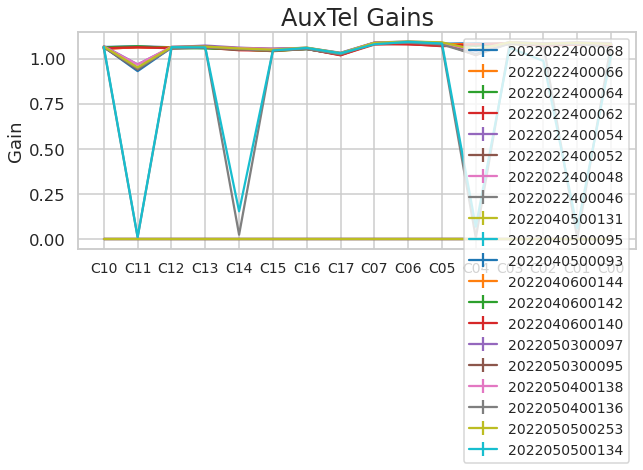

In [182]:
plt.figure(figsize=(10,4))
plt.title("AuxTel Gains", fontsize=24)
amp_nums = data['amps']
for i,data in enumerate(data_list):
    gains = data['gain']
    gain_err = data['gain_err']
    plt.errorbar(amp_nums, gains, yerr=gain_err, label = run_names[i])#, marker = markers[i]
    #plt.ylim(0.95, 1.4) 
    plt.ylabel("Gain")
    plt.xticks(amp_nums,amps, fontsize=14)
    plt.legend(loc = 'upper right', fontsize = 14)

# plt.savefig(f'./plots/Gain_Summary_{date}.pdf',dpi=100)